## Imports

In [1]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist

import pickle

# Get our waveform training set

In [2]:
# read in waveform dataframe

waveforms = pd.read_parquet('../../../Data/all_msci_waveforms_df.parquet')
print('Waveforms Set')
waveforms.info()
waveforms.head()

Waveforms Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18139 entries, 0 to 18138
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   runID    18139 non-null  uint64
 1   eventID  18139 non-null  uint64
 2   times    18139 non-null  object
 3   samples  18139 non-null  object
 4   length   18139 non-null  int64 
dtypes: int64(1), object(2), uint64(2)
memory usage: 708.7+ KB


,runID,eventID,times,samples,length
0,6940,941,"[-1442.0, -1432.0, -1422.0, -1412.0, -1402.0, ...","[0.00371349323540926, 0.011231761425733566, 0....",450
1,6940,2797,"[-3062.0, -3052.0, -3042.0, -3032.0, -3022.0, ...","[-0.0005877960938960314, 0.0009018611162900925...",865
2,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101
3,6940,3705,"[-522.0, -512.0, -502.0, -492.0, -482.0, -472....","[0.0011612486559897661, 0.009089636616408825, ...",600
4,6940,6386,"[-2032.0, -2022.0, -2012.0, -2002.0, -1992.0, ...","[0.00023173866793513298, 0.0002317386679351329...",466


In [3]:
# read in tritium and background datasets and combine

trit_data = pd.read_csv('../../../Data/tritium_ML_data.csv')
bkg_data = pd.read_csv('../../../Data/bg_sr1_vetoes_gassplit.csv')
orig_train = pd.concat([trit_data, bkg_data], ignore_index=True)
orig_train = orig_train.drop('Unnamed: 0', axis = 1)
print('Original Dataset')
orig_train.info()
orig_train.head()

Original Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23517 entries, 0 to 23516
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             23517 non-null  int64  
 1   eventID           23517 non-null  int64  
 2   area              23517 non-null  float64
 3   max_pulse_height  23517 non-null  float64
 4   ext_elec          23517 non-null  float64
 5   x                 23517 non-null  float64
 6   y                 23517 non-null  float64
 7   r                 23517 non-null  float64
 8   S2_width          23517 non-null  float64
 9   label             23517 non-null  int64  
 10  type              23517 non-null  object 
 11  dt10_05           23517 non-null  float64
 12  dt25_10           23517 non-null  float64
 13  dt50_25           23517 non-null  float64
 14  dt75_50           23517 non-null  float64
 15  dt90_75           23517 non-null  float64
 16  dt95_90           23517

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


- Binary Classification: 
    - Background - 0
    - Signal - 1
- Multi-class Classification:
    - Cathode - 0
    - Gate - 1
    - Tritium - 2

In [4]:
# Remove gas events from our waveform set
# Then set background events to a label=0 and signal calibration events to a label=1

final_dataset = data.waveforms_of_truth(waveforms, orig_train)
df_gas_cut = final_dataset[final_dataset["type"] != 'gas']
# df_gas_cut.loc[df_gas_cut["type"] == "tritium", "label"] = 1
# df_gas_cut.loc[df_gas_cut["type"] == "gate", "label"] = 0
df_gas_cut.info()
df_gas_cut.head()

Rows with length = 0 have been removed from the waveform data set
<class 'pandas.core.frame.DataFrame'>
Index: 9686 entries, 2 to 17602
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             9686 non-null   uint64 
 1   eventID           9686 non-null   uint64 
 2   times             9686 non-null   object 
 3   samples           9686 non-null   object 
 4   length            9686 non-null   int64  
 5   area              9686 non-null   float64
 6   max_pulse_height  9686 non-null   float64
 7   ext_elec          9686 non-null   float64
 8   x                 9686 non-null   float64
 9   y                 9686 non-null   float64
 10  r                 9686 non-null   float64
 11  S2_width          9686 non-null   float64
 12  label             9686 non-null   int64  
 13  type              9686 non-null   object 
dtypes: float64(7), int64(2), object(3), uint64(2)
memory usage: 1.1+ MB


,runID,eventID,times,samples,length,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type
2,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101,9605.476562,2.721810,204.067911,42.940289,28.632875,51.611142,11120.0,0,cathode
3,6940,3705,"[-522.0, -512.0, -502.0, -492.0, -482.0, -472....","[0.0011612486559897661, 0.009089636616408825, ...",600,1831.674072,2.608893,38.913832,23.994717,41.210274,47.686823,1920.0,1,gate
6,6940,7831,"[-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...","[0.0009631378925405443, 0.0009631378925405443,...",932,8454.574219,2.998639,179.617043,-10.792992,-21.832264,24.354392,8570.0,0,cathode
8,6940,9904,"[-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...","[-0.003676149994134903, -0.004674938507378101,...",525,10806.775391,7.274445,229.589450,45.577667,18.305967,49.116516,3760.0,1,gate
11,6940,15136,"[-823.0, -813.0, -803.0, -793.0, -783.0, -773....","[-0.004523166920989752, 0.0026921471580863, -0...",640,11460.135742,8.490430,243.470060,28.943817,44.150917,52.792500,2810.0,1,gate


## Get the weights of the dataset based on S2 size

In [5]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

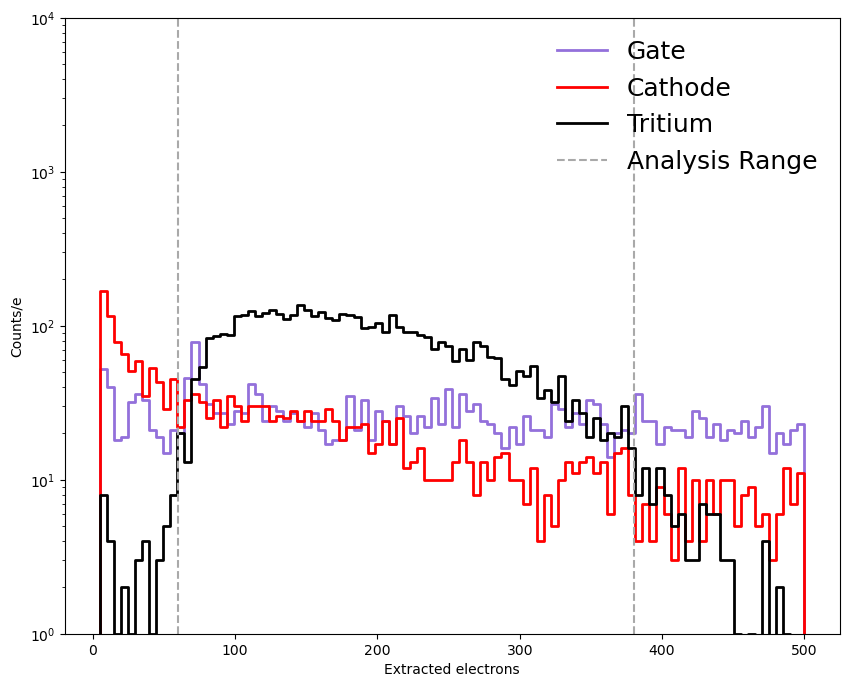

In [6]:
gate_hist = Hist(electron_axis)
gate_cut = df_gas_cut.type == "gate"
gate_hist.fill(df_gas_cut.ext_elec[gate_cut])

# gas_hist = Hist(electron_axis)
# gas_cut = padded_data.type == "gas"
# gas_hist.fill(padded_data.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df_gas_cut.type == "cathode"
cath_hist.fill(df_gas_cut.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df_gas_cut.type == "tritium"
trit_hist.fill(df_gas_cut.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
# gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [7]:
# implementing thresholds
thresh_cut = (60 < df_gas_cut.ext_elec) & (df_gas_cut.ext_elec < 380)
df_gas_and_thresh_cut = df_gas_cut[thresh_cut].reset_index().drop('index', axis = 1)

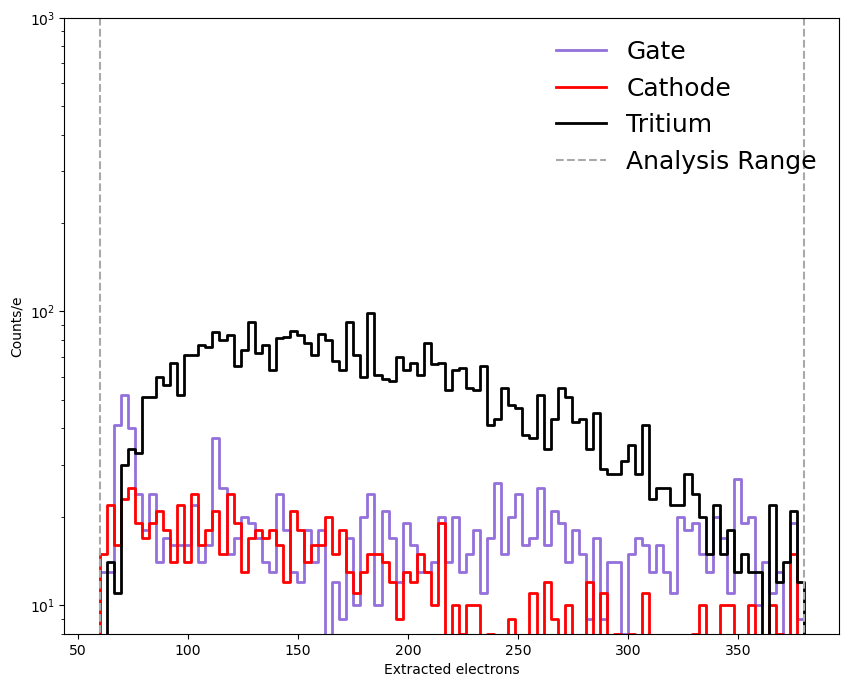

In [8]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_gas_and_thresh_cut.type == "gate"
gate_hist2.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_gas_and_thresh_cut.type == "cathode"
cath_hist2.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_gas_and_thresh_cut.type == "tritium"
trit_hist2.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2])

# gas_hist2 = Hist(electron_axis2)
# gas_cut2 = padded_data.type == "gas"
# gas_hist2.fill(padded_data.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
# gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [9]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_gas_and_thresh_cut.shape[0]):
    if df_gas_and_thresh_cut.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_gas_and_thresh_cut.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_gas_and_thresh_cut.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_gas_and_thresh_cut['weights_no_gas'] = weight_list
print(df_gas_and_thresh_cut['weights_no_gas'].to_numpy().shape)

(7782,)


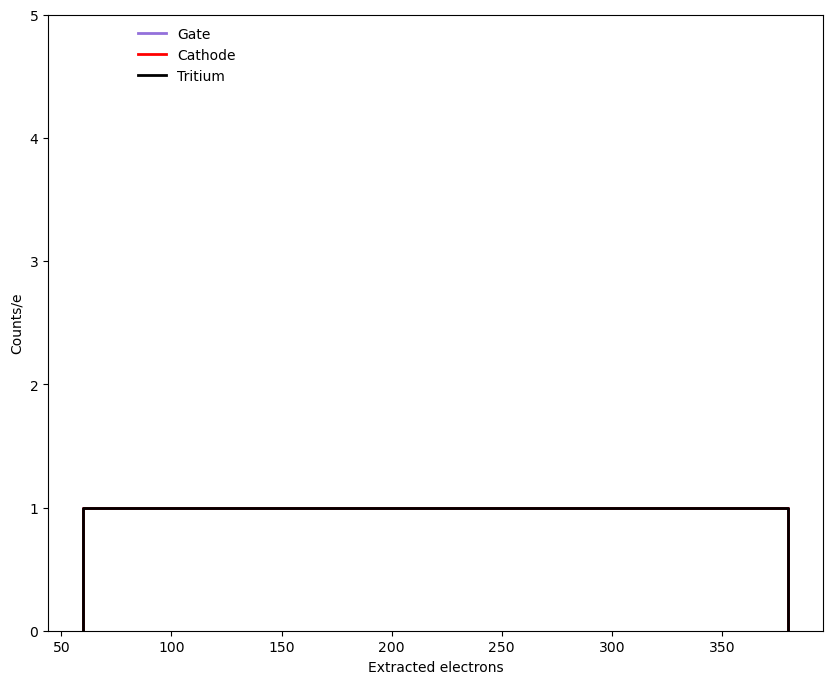

In [10]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

## Final ML Datasets

In [11]:
# prepare data for machine learning
# pad on data set after threshold cut and 

padded_data = data.pad_waveforms(df_gas_and_thresh_cut,padding_name='chonkers',padding_length=1200)
print('Waveform Dataset')
padded_data.info()
print('\nMax Waveform Length - ' + str(padded_data.length.max()))

print('\nPadded Waveform Length - ' + str(len(padded_data.chonkers[0])))

padded_data.to_parquet('../../../Data/padded_waveforms.parquet')

Waveform Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7782 entries, 0 to 7781
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             7782 non-null   uint64 
 1   eventID           7782 non-null   uint64 
 2   times             7782 non-null   object 
 3   samples           7782 non-null   object 
 4   length            7782 non-null   int64  
 5   area              7782 non-null   float64
 6   max_pulse_height  7782 non-null   float64
 7   ext_elec          7782 non-null   float64
 8   x                 7782 non-null   float64
 9   y                 7782 non-null   float64
 10  r                 7782 non-null   float64
 11  S2_width          7782 non-null   float64
 12  label             7782 non-null   int64  
 13  type              7782 non-null   object 
 14  weights_no_gas    7782 non-null   float64
 15  chonkers          7782 non-null   object 
dtypes: float64(8), int64(2), 

In [33]:
sigma_list=[0,1,2,3,4,5]
std_list=[0.005,0.01,0.05,0.1]
type_list=['gaussian','constant','edge','reflect']
gauss_names=['gauss0.005','gauss0.01','gauss0.05','gauss0.1']
for i in range(len(std_list)):
    data.pad_waveforms(df_gas_and_thresh_cut,gauss_names[i],padding_length=1200,padding_type='gaussian',std=std_list[i])
data.pad_waveforms(df_gas_and_thresh_cut,padding_length=1200,padding_name='constant_padding',padding_type='constant')
data.pad_waveforms(df_gas_and_thresh_cut,padding_length=1200,padding_name='edge_padding',padding_type='edge')
data.pad_waveforms(df_gas_and_thresh_cut,padding_length=1200,padding_name='reflect_padding',padding_type='reflect')

,runID,eventID,times,samples,length,area,max_pulse_height,ext_elec,x,y,...,label,type,weights_no_gas,gauss0.005,gauss0.01,gauss0.05,gauss0.1,constant_padding,edge_padding,reflect_padding
0,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101,9605.476562,2.721810,204.067911,42.940289,28.632875,...,0,cathode,0.066667,"[0.005227473949113218, 0.006297921592003455, -...","[-0.020500222406334506, -0.00449523991625305, ...","[0.028602515019371375, -0.03168807512970744, 0...","[0.023305869736904364, 0.10860196140891232, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,6940,7831,"[-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...","[0.0009631378925405443, 0.0009631378925405443,...",932,8454.574219,2.998639,179.617043,-10.792992,-21.832264,...,0,cathode,0.076923,"[-0.004873616380359024, -1.1205731477779456e-0...","[0.0176679412878648, -0.004158965394114593, 0....","[-0.03535402229269096, -0.024688952659549315, ...","[-0.06827942837151517, 0.19209721097215185, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6940,9904,"[-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...","[-0.003676149994134903, -0.004674938507378101,...",525,10806.775391,7.274445,229.589450,45.577667,18.305967,...,1,gate,0.066667,"[-0.010634938986575287, -0.0004093572397683614...","[0.015334479381291623, 0.0029332130702961826, ...","[-0.012763404234418933, 0.00011756537361659906...","[0.03686347991360555, 0.1170538833253372, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,6940,15136,"[-823.0, -813.0, -803.0, -793.0, -783.0, -773....","[-0.004523166920989752, 0.0026921471580863, -0...",640,11460.135742,8.490430,243.470060,28.943817,44.150917,...,1,gate,0.066667,"[0.0014216045376818443, 0.0016209030468685764,...","[-0.0048572866285346685, -0.007516558558585098...","[-0.0038534972754623712, -0.0742466713779216, ...","[0.17044434897884964, -0.09881085245088873, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6940,16478,"[-813.0, -803.0, -793.0, -783.0, -773.0, -763....","[-0.009625015780329704, -0.004182628821581602,...",656,11764.575195,8.766376,249.937863,-22.589451,23.071259,...,1,gate,0.041667,"[-0.006354493793357637, -0.007267074931397738,...","[-0.003229276154789218, -0.0003650018817644175...","[0.07389852488726147, 0.06359567669631855, -0....","[-0.07278499383884955, 0.0003005390172088577, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7777,8172,146375,"[-1642.0, -1632.0, -1622.0, -1612.0, -1602.0, ...","[0.0006020283326506615, -0.0001504611573182046...",447,3772.321533,2.478832,80.142799,15.835625,13.181137,...,2,tritium,0.019608,"[-0.0020654934463559325, 0.0018528899198868606...","[0.017287135486233993, -0.001136839200873142, ...","[0.005527887162045688, -0.1009254699817594, -0...","[-0.02121284461734239, -0.14824794751535672, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7778,8172,146918,"[-2062.0, -2052.0, -2042.0, -2032.0, -2022.0, ...","[0.0006466679042205215, 0.0014018205692991614,...",671,6177.657715,3.737255,131.244056,11.203719,47.689232,...,2,tritium,0.013889,"[-0.004372219245103128, 0.002445723604163989, ...","[-0.02440319500427668, 0.00099574406676809, 0....","[0.0031747070023722974, -0.09863679911056741, ...","[-0.001766

In [35]:
data_list=['gauss0.005','gauss0.01','gauss0.05','gauss0.1','constant_padding','edge_padding']
ML_data={name:data.make_ML_data(df_gas_and_thresh_cut,name) for name in data_list}

# Making the model

#### Going to start with input layer with no. neurons as the length of the waveform arrays, one fully connected hidden layer, and an output layer of two neurons

In [40]:
results_dict={'accuracy':[],'history':[],'predicted':[]}
for padding_type in data_list:
    
    X_train, X_test, \
    y_train, y_test, \
    W_train, W_test, \
    runID_train, runID_test, \
    eventID_train, eventID_test = ML_data[padding_type]['data']
    
    paddedNN = keras.Sequential([
    keras.layers.Dense(100,input_shape=(input_length,),activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3,activation='softmax')])
    
    paddedNN.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',#'binary_crossentropy',
    metrics=['accuracy'],
    weighted_metrics=['accuracy'])
    
    hist_paddedNN = paddedNN.fit(X_train,y_train,epochs=40, validation_split=0.2, shuffle=True, sample_weight=W_train)
    results_dict['accuracy'].append(paddedNN.evaluate(X_test,y_test, sample_weight=W_test)) 
    results_dict['history'].append(hist_paddedNN.history)
    results_dict['predicted'].append(paddedNN.predict(X_test))
    with open('masked/{}{}'.format(padding_type,'.pkl'),'wb') as f:
            pickle.dump(paddedNN, f)
    results=pd.DataFrame(results_dict)
    results.to_csv('results.csv')
    print(padding_type)



Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0256 - accuracy: 0.6808 - weighted_accuracy: 0.7504 - val_loss: 0.0194 - val_accuracy: 0.7680 - val_weighted_accuracy: 0.8321
Epoch 2/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0183 - accuracy: 0.7744 - weighted_accuracy: 0.8364 - val_loss: 0.0167 - val_accuracy: 0.8288 - val_weighted_accuracy: 0.8713
Epoch 3/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0163 - accuracy: 0.7939 - weighted_accuracy: 0.8516 - val_loss: 0.0154 - val_accuracy: 0.8168 - val_weighted_accuracy: 0.8757
Epoch 4/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0153 - accuracy: 0.8121 - weighted_accuracy: 0.8690 - val_loss: 0.0141 - val_accuracy: 0.8450 - val_weighted_accuracy: 0.8771
Epoch 5/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0147 - accuracy: 0.8111 - weighted_accuracy: 0.8634 - val_loss: 0.0154 - val_accuracy: 0.7911 - val_weighted_accurac

61/61 [==============================] - 0s 2ms/step
gauss0.005
Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0264 - accuracy: 0.6677 - weighted_accuracy: 0.7296 - val_loss: 0.0211 - val_accuracy: 0.7568 - val_weighted_accuracy: 0.7319
Epoch 2/40
146/146 [==============================] - 1s 6ms/step - loss: 0.0193 - accuracy: 0.7665 - weighted_accuracy: 0.8229 - val_loss: 0.0170 - val_accuracy: 0.8211 - val_weighted_accuracy: 0.8406
Epoch 3/40
146/146 [==============================] - 1s 6ms/step - loss: 0.0172 - accuracy: 0.7849 - weighted_accuracy: 0.8450 - val_loss: 0.0152 - val_accuracy: 0.8142 - val_weighted_accuracy: 0.8753
Epoch 4/40
146/146 [==============================] - 1s 7ms/step - loss: 0.0156 - accuracy: 0.8106 - weighted_accuracy: 0.8692 - val_loss: 0.0147 - val_accuracy: 0.8416 - val_weighted_accuracy: 0.8876
Epoch 5/40
146/146 [==============================] - 1s 6ms/step - loss: 0.0149 - accuracy: 0.8141 - weighted_accuracy: 0.8675 

61/61 [==============================] - 0s 1ms/step
gauss0.01
Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0265 - accuracy: 0.6425 - weighted_accuracy: 0.7246 - val_loss: 0.0223 - val_accuracy: 0.8219 - val_weighted_accuracy: 0.6934
Epoch 2/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0186 - accuracy: 0.7738 - weighted_accuracy: 0.8335 - val_loss: 0.0164 - val_accuracy: 0.7697 - val_weighted_accuracy: 0.8560
Epoch 3/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0166 - accuracy: 0.8029 - weighted_accuracy: 0.8574 - val_loss: 0.0160 - val_accuracy: 0.7543 - val_weighted_accuracy: 0.8512
Epoch 4/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0155 - accuracy: 0.8074 - weighted_accuracy: 0.8635 - val_loss: 0.0149 - val_accuracy: 0.8467 - val_weighted_accuracy: 0.8747
Epoch 5/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0143 - accuracy: 0.8198 - weighted_accuracy: 0.8767 -

146/146 [==============================] - 1s 5ms/step - loss: 0.0052 - accuracy: 0.9261 - weighted_accuracy: 0.9566 - val_loss: 0.0153 - val_accuracy: 0.8741 - val_weighted_accuracy: 0.8653
Epoch 40/40
61/61 [==============================] - 0s 1ms/step
gauss0.05
Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0270 - accuracy: 0.6885 - weighted_accuracy: 0.7270 - val_loss: 0.0199 - val_accuracy: 0.6884 - val_weighted_accuracy: 0.8198
Epoch 2/40
146/146 [==============================] - 1s 8ms/step - loss: 0.0181 - accuracy: 0.7787 - weighted_accuracy: 0.8423 - val_loss: 0.0159 - val_accuracy: 0.8365 - val_weighted_accuracy: 0.8691
Epoch 3/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0158 - accuracy: 0.8029 - weighted_accuracy: 0.8633 - val_loss: 0.0157 - val_accuracy: 0.7800 - val_weighted_accuracy: 0.8604
Epoch 4/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0147 - accuracy: 0.8138 - weighted_accuracy: 0.8699 

146/146 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.9689 - weighted_accuracy: 0.9850 - val_loss: 0.0207 - val_accuracy: 0.8750 - val_weighted_accuracy: 0.8292
Epoch 39/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0023 - accuracy: 0.9722 - weighted_accuracy: 0.9878 - val_loss: 0.0201 - val_accuracy: 0.8741 - val_weighted_accuracy: 0.8278
Epoch 40/40
61/61 [==============================] - 0s 1ms/step
gauss0.1
Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0266 - accuracy: 0.6844 - weighted_accuracy: 0.7335 - val_loss: 0.0196 - val_accuracy: 0.7731 - val_weighted_accuracy: 0.8382
Epoch 2/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0186 - accuracy: 0.7659 - weighted_accuracy: 0.8361 - val_loss: 0.0166 - val_accuracy: 0.7577 - val_weighted_accuracy: 0.8518
Epoch 3/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0166 - accuracy: 0.7937 - weighted_accuracy: 0.8538 

146/146 [==============================] - 1s 5ms/step - loss: 0.0106 - accuracy: 0.8533 - weighted_accuracy: 0.8953 - val_loss: 0.0136 - val_accuracy: 0.8639 - val_weighted_accuracy: 0.8956
Epoch 38/40
146/146 [==============================] - 1s 6ms/step - loss: 0.0105 - accuracy: 0.8605 - weighted_accuracy: 0.8974 - val_loss: 0.0138 - val_accuracy: 0.8502 - val_weighted_accuracy: 0.8893
Epoch 39/40
146/146 [==============================] - 1s 7ms/step - loss: 0.0104 - accuracy: 0.8590 - weighted_accuracy: 0.8966 - val_loss: 0.0137 - val_accuracy: 0.8450 - val_weighted_accuracy: 0.8910
Epoch 40/40
61/61 [==============================] - 0s 1ms/step
constant_padding
Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0258 - accuracy: 0.6799 - weighted_accuracy: 0.7537 - val_loss: 0.0205 - val_accuracy: 0.8211 - val_weighted_accuracy: 0.7533
Epoch 2/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0185 - accuracy: 0.7796 - weighted_accuracy

146/146 [==============================] - 1s 5ms/step - loss: 0.0105 - accuracy: 0.8556 - weighted_accuracy: 0.8960 - val_loss: 0.0135 - val_accuracy: 0.8596 - val_weighted_accuracy: 0.8826
Epoch 37/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0108 - accuracy: 0.8533 - weighted_accuracy: 0.8918 - val_loss: 0.0135 - val_accuracy: 0.8373 - val_weighted_accuracy: 0.8848
Epoch 38/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0102 - accuracy: 0.8556 - weighted_accuracy: 0.9015 - val_loss: 0.0137 - val_accuracy: 0.8776 - val_weighted_accuracy: 0.8874
Epoch 39/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0105 - accuracy: 0.8590 - weighted_accuracy: 0.9012 - val_loss: 0.0137 - val_accuracy: 0.8622 - val_weighted_accuracy: 0.8730
Epoch 40/40
61/61 [==============================] - 0s 1ms/step
edge_padding


In [15]:
paddedNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                 metrics=['accuracy'],
                 weighted_metrics=['accuracy'])

In [16]:
[print(i.shape, i.dtype) for i in paddedNN.inputs]
[print(o.shape, o.dtype) for o in paddedNN.outputs]
[print(l.name, l.input_shape, l.dtype) for l in paddedNN.layers]

(None, 3028) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
dense (None, 3028) float32
dropout (None, 100) float32
dense_1 (None, 100) float32


[None, None, None]

In [17]:
hist_paddedNN = paddedNN.fit(X_train,y_train,epochs=40, validation_split=0.2, shuffle=True, sample_weight=W_train)

Epoch 1/40
146/146 [==============================] - 2s 7ms/step - loss: 0.0259 - accuracy: 0.6712 - weighted_accuracy: 0.7349 - val_loss: 0.0191 - val_accuracy: 0.7748 - val_weighted_accuracy: 0.8416
Epoch 2/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0181 - accuracy: 0.7909 - weighted_accuracy: 0.8505 - val_loss: 0.0159 - val_accuracy: 0.8193 - val_weighted_accuracy: 0.8642
Epoch 3/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0163 - accuracy: 0.7920 - weighted_accuracy: 0.8561 - val_loss: 0.0148 - val_accuracy: 0.8262 - val_weighted_accuracy: 0.8775
Epoch 4/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0153 - accuracy: 0.8078 - weighted_accuracy: 0.8619 - val_loss: 0.0143 - val_accuracy: 0.8211 - val_weighted_accuracy: 0.8688
Epoch 5/40
146/146 [==============================] - 1s 5ms/step - loss: 0.0145 - accuracy: 0.8239 - weighted_accuracy: 0.8764 - val_loss: 0.0142 - val_accuracy: 0.8134 - val_weighted_accurac

## Evaluating the model

In [18]:
print('Test Loss, Test Accuracy]')
paddedNN.evaluate(X_test,y_test, sample_weight=W_test)

Test Loss, Test Accuracy]
61/61 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.8489 - weighted_accuracy: 0.8831


[0.018217584118247032, 0.8489208817481995, 0.8831272721290588]

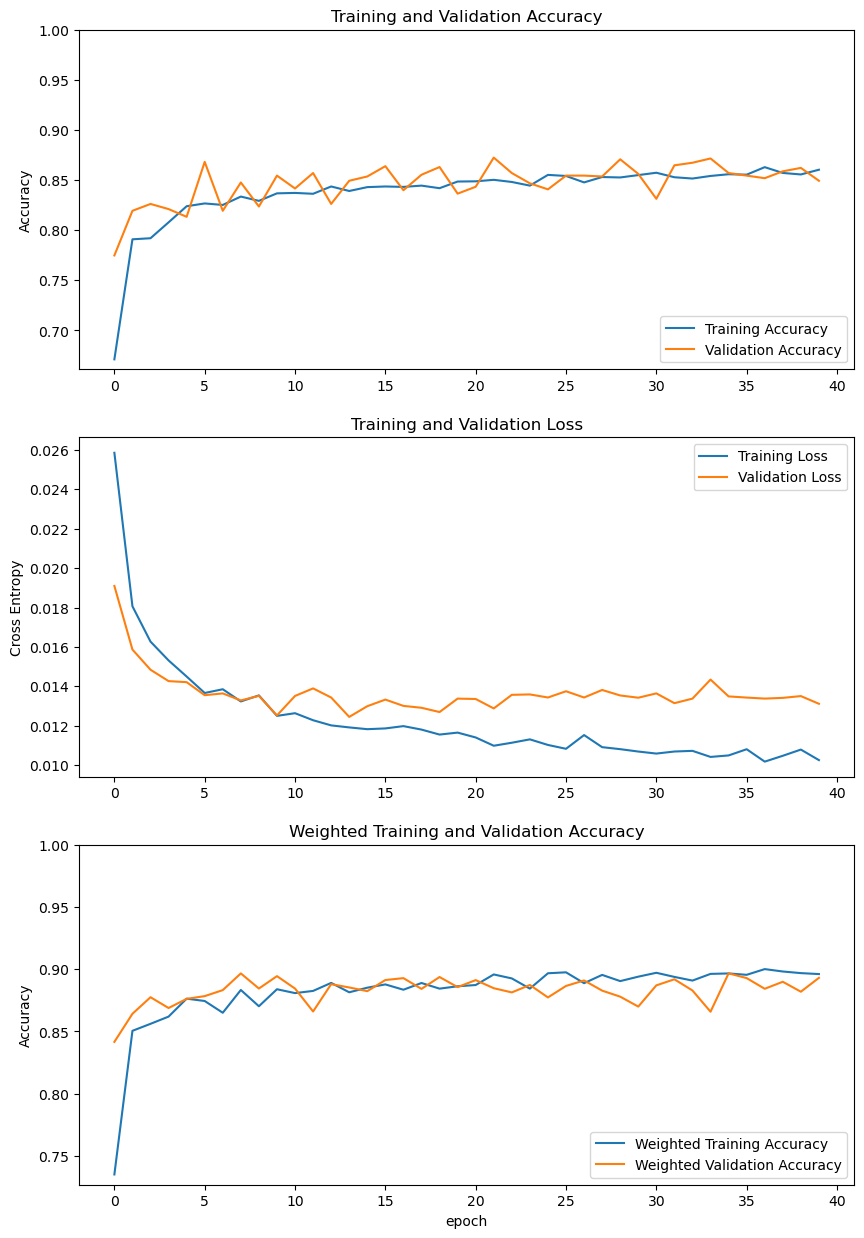

In [19]:
# plotting training history

acc = hist_paddedNN.history['accuracy']
val_acc = hist_paddedNN.history['val_accuracy']
w_acc = hist_paddedNN.history['weighted_accuracy']
w_val_acc = hist_paddedNN.history['val_weighted_accuracy']

loss = hist_paddedNN.history['loss']
val_loss = hist_paddedNN.history['val_loss']

plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

# plotting weighted mertrics

plt.subplot(3, 1, 3)
plt.plot(w_acc, label='Weighted Training Accuracy')
plt.plot(w_val_acc, label='Weighted Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Weighted Training and Validation Accuracy')
plt.xlabel('epoch')

plt.show()



In [20]:
# generating confusion matrix info

#y_probs = paddedNN.predict(X_test)
# y_predicted_label = (y_probs > 0.5).astype(int)
#y_probs[0], y_predicted_label[0]
#print(y_predicted)

y_predicted = paddedNN.predict(X_test)
y_predicted_label = [np.argmax(i) for i in y_predicted]

61/61 [==============================] - 0s 1ms/step


Text(95.72222222222221, 0.5, 'Truth')

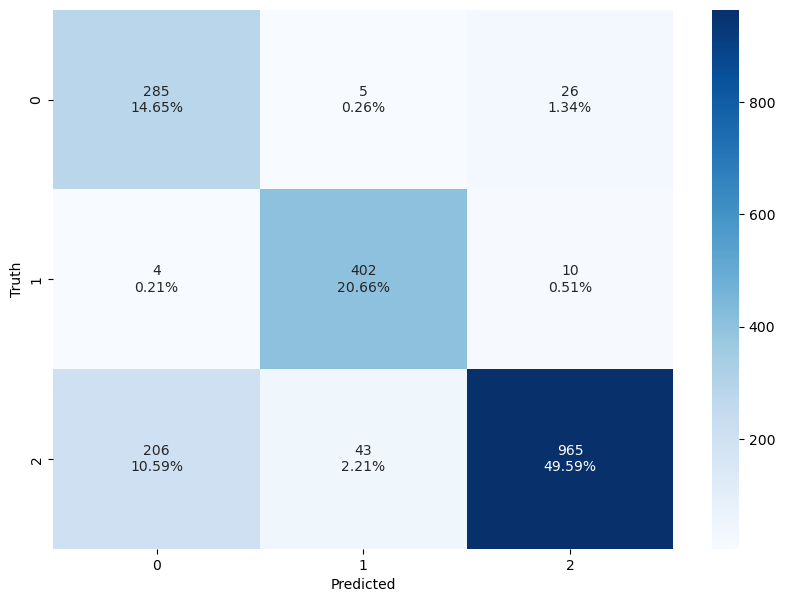

In [21]:
# plotting confusion matrix

# plt.figure(figsize = (10,7))
# sns.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label),
#            annot=True, 
#            fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

plt.figure(figsize = (10,7))
cf_matrix = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label).numpy()

# group_names = ['True Cathode','False Gate', 'False Signal', 
#                'False Cathode','True Gate', 'False Signal',
#                'False']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
          #zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')